# SHAP 분석 노트북: ETRI Lifelog Dataset

## 목적
이 노트북은 ETRI Lifelog Dataset 2024의 Q1 예측 모델에 대한 SHAP(SHapley Additive exPlanations) 분석을 수행합니다.

SHAP 분석을 통해:
- 각 특성(feature)이 개별 예측에 어떻게 기여하는지 이해
- 모델의 전역적(global) 특성 중요도 파악
- 특성 간 상호작용 효과 분석
- 개별 샘플에 대한 설명 제공

## 분석 단계
1. 환경 설정 및 데이터 로드
2. 모델 로드 및 검증
3. SHAP 값 계산
4. 다양한 시각화 및 해석


In [4]:
# !pip install matplotlib
# !pip install seaborn
# !pip install shap

In [18]:
# 1. 환경 설정 및 라이브러리 임포트
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# SHAP 라이브러리
try:
    import shap
    print(f"SHAP 버전: {shap.__version__}")
except ImportError:
    print("SHAP 라이브러리가 설치되지 않았습니다. 'pip install shap' 명령으로 설치해주세요.")
    raise

# 경로 설정
ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name=="notebook" else Path.cwd()
PROC = ROOT / "data" / "processed" / "etrilifelog"
ART = ROOT / "artifacts"
RAW = ROOT / "data" / "raw"

SHAP 버전: 0.49.1


## 1. 데이터 로드 및 탐색

데이터셋의 기본 정보를 확인하고, 모델 학습에 사용된 특성과 타겟 변수를 확인합니다.


In [ ]:
# 데이터셋 로드
ds = pd.read_parquet(PROC / "metrics_only.parquet")
print(f"데이터셋 크기: {ds.shape}")
print(f"\n컬럼 목록:")
print(ds.columns.tolist())
print(f"\n데이터 타입:")
print(ds.dtypes)


데이터셋 크기: (450, 11)

컬럼 목록:
['subject_id', 'lifelog_date', 'sleep_date', 'dow', 'is_weekend', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']

데이터 타입:
subject_id            category
lifelog_date    datetime64[ns]
sleep_date      datetime64[ns]
dow                       int8
is_weekend                int8
Q1                        int8
Q2                        int8
Q3                        int8
S1                        int8
S2                        int8
S3                        int8
dtype: object


In [16]:
ds.head()

,subject_id,lifelog_date,sleep_date,dow,is_weekend,Q1,Q2,Q3,S1,S2,S3
0,id01,2024-06-26,2024-06-27,2,0,0,0,0,0,0,1
1,id01,2024-06-27,2024-06-28,3,0,0,0,0,0,1,1
2,id01,2024-06-28,2024-06-29,4,0,1,0,0,1,1,1
3,id01,2024-06-29,2024-06-30,5,1,1,0,1,2,0,0
4,id01,2024-06-30,2024-07-01,6,1,0,1,1,1,1,1


In [17]:
print(f"\n기본 통계:")
ds.describe()


기본 통계:


,lifelog_date,sleep_date,dow,is_weekend,Q1,Q2,Q3,S1,S2,S3
count,450,450,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,2024-08-08 14:36:48,2024-08-09 14:36:48,3.048889,0.300000,0.495556,0.562222,0.600000,0.866667,0.651111,0.662222
min,2024-06-03 00:00:00,2024-06-04 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-07-13 00:00:00,2024-07-14 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2024-08-04 00:00:00,2024-08-05 00:00:00,3.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2024-08-31 00:00:00,2024-09-01 00:00:00,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2024-11-14 00:00:00,2024-11-15 00:00:00,6.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000
std,NaN,NaN,2.023759,0.458768,0.500537,0.496665,0.490443,0.696795,0.477149,0.473479


In [20]:
# 데이터셋 카탈로그 정보 확인
catalog = json.loads((ART / "dataset_catalog.json").read_text())
print("데이터셋 카탈로그:")
print(json.dumps(catalog, ensure_ascii=False, indent=2))


데이터셋 카탈로그:
{
  "dataset": "ETRI Lifelog 2024",
  "rows": 450,
  "subjects": 10,
  "date_range": {
    "min": "2024-06-03",
    "max": "2024-11-14"
  },
  "targets": {
    "Q1": {
      "0": 227,
      "1": 223
    },
    "Q2": {
      "1": 253,
      "0": 197
    },
    "Q3": {
      "1": 270,
      "0": 180
    },
    "S1": {
      "1": 224,
      "0": 143,
      "2": 83
    },
    "S2": {
      "1": 293,
      "0": 157
    },
    "S3": {
      "1": 298,
      "0": 152
    }
  }
}


In [21]:

# 배경 샘플 정보 확인
bg_info = json.loads((ART / "background_idx.json").read_text())
print(f"\n배경 샘플 크기: {bg_info['size']}")
print(f"배경 샘플 시드: {bg_info['seed']}")



배경 샘플 크기: 450
배경 샘플 시드: 42


In [22]:

# phi0 정보 확인
phi0_info = json.loads((ART / "phi0_q1.json").read_text())
print(f"\n기저값(phi0) 정보:")
print(json.dumps(phi0_info, indent=2))



기저값(phi0) 정보:
{
  "link": "prob",
  "phi0": 0.49553997834369107
}


In [24]:
# 모델 학습에 사용된 특성과 타겟 변수 추출
feature_cols = ["dow", "is_weekend"]  # 요일(day of week), 주말 여부
target_col = "Q1"

X = ds[feature_cols].copy()
y = ds[target_col].copy()

print(f"특성 변수: {feature_cols}")
print(f"타겟 변수: {target_col}")

특성 변수: ['dow', 'is_weekend']
타겟 변수: Q1


In [25]:
print(f"\n특성 변수 분포:")
X.describe()


특성 변수 분포:


,dow,is_weekend
count,450.000000,450.000000
mean,3.048889,0.300000
std,2.023759,0.458768
min,0.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,6.000000,1.000000


In [26]:
print(f"\n타겟 변수 분포:")
y.value_counts().sort_index()


타겟 변수 분포:


Q1
0    227
1    223
Name: count, dtype: int64

In [27]:
print(f"\n타겟 변수 비율:")
y.value_counts(normalize=True).sort_index()


타겟 변수 비율:


Q1
0    0.504444
1    0.495556
Name: proportion, dtype: float64

## 2. 모델 로드 및 검증

학습된 모델을 로드하고 예측 성능을 확인합니다.


In [10]:
# 모델 로드
model_path = ART / "model_q1_logit.joblib"
model = joblib.load(model_path)
print(f"모델 타입: {type(model)}")
print(f"\n모델 파라미터:")
print(f"  - 클래스: {model.classes_}")
print(f"  - 절편(intercept): {model.intercept_[0]:.6f}")
print(f"  - 계수(coef): {dict(zip(feature_cols, model.coef_[0]))}")


모델 타입: <class 'sklearn.linear_model._logistic.LogisticRegression'>

모델 파라미터:
  - 클래스: [0 1]
  - 절편(intercept): -0.114694
  - 계수(coef): {'dow': np.float64(0.059023888854384525), 'is_weekend': np.float64(-0.2770407352538158)}


In [29]:
# 모델 예측 확인
y_pred_proba = model.predict_proba(X)[:, 1]
y_pred = model.predict(X)

print(f"예측 확률 통계:")
pd.Series(y_pred_proba).describe()

예측 확률 통계:


count    450.000000
mean       0.495540
std        0.019568
min        0.471358
25%        0.475865
50%        0.490603
75%        0.515589
max        0.530313
dtype: float64

In [30]:
print(f"\n예측 클래스 분포:")
pd.Series(y_pred).value_counts().sort_index()


예측 클래스 분포:


0    260
1    190
Name: count, dtype: int64

In [31]:
print(f"\n실제 클래스 분포:")
y.value_counts().sort_index()


실제 클래스 분포:


Q1
0    227
1    223
Name: count, dtype: int64

In [32]:
# 정확도 확인
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
accuracy = accuracy_score(y, y_pred)
auc = roc_auc_score(y, y_pred_proba)
print(f"\n모델 성능:")
print(f"  - 정확도: {accuracy:.4f}")
print(f"  - AUROC: {auc:.4f}")
print(f"\n혼동 행렬:")
print(confusion_matrix(y, y_pred))


모델 성능:
  - 정확도: 0.5222
  - AUROC: 0.5142

혼동 행렬:
[[136  91]
 [124  99]]


## 3. SHAP 값 계산

SHAP는 각 특성이 예측에 기여하는 정도를 정량화합니다. 
- **기저값(φ₀)**: 배경 분포에서의 평균 예측값
- **SHAP 값(φᵢ)**: 각 특성이 기저값에서 얼마나 기여하는지

### 3.1 배경 샘플 준비
배경 샘플은 SHAP 계산의 기준점으로 사용됩니다.


In [12]:
# 배경 샘플 인덱스 로드
bg_idx = json.loads((ART / "background_idx.json").read_text())["index"]
X_background = X.iloc[bg_idx].copy()

print(f"배경 샘플 크기: {len(X_background)}")
print(f"\n배경 샘플 통계:")
print(X_background.describe())
print(f"\n배경 샘플 특성 분포:")
for col in feature_cols:
    print(f"\n{col}:")
    print(X_background[col].value_counts().sort_index())


배경 샘플 크기: 450

배경 샘플 통계:
              dow  is_weekend
count  450.000000  450.000000
mean     3.048889    0.300000
std      2.023759    0.458768
min      0.000000    0.000000
25%      1.000000    0.000000
50%      3.000000    0.000000
75%      5.000000    1.000000
max      6.000000    1.000000

배경 샘플 특성 분포:

dow:
dow
0    65
1    60
2    64
3    65
4    61
5    65
6    70
Name: count, dtype: int64

is_weekend:
is_weekend
0    315
1    135
Name: count, dtype: int64


In [34]:
# 모델 래퍼 함수 정의 (확률 출력)
def model_predict_proba(X_input):
    """모델 예측 함수 (확률 출력)"""
    if isinstance(X_input, pd.DataFrame):
        return model.predict_proba(X_input.values)[:, 1]
    else:
        return model.predict_proba(X_input)[:, 1]

# Linear SHAP Explainer 생성 (선형 모델에 최적화)
# LinearExplainer는 선형 모델의 SHAP 값을 정확하게 계산합니다.
explainer_linear = shap.LinearExplainer(
    model, 
    X_background,
)

print("Linear SHAP Explainer 생성 완료")
print(f"특성 개수: {len(feature_cols)}")
print(f"배경 샘플 크기: {len(X_background)}")


Linear SHAP Explainer 생성 완료
특성 개수: 2
배경 샘플 크기: 450


In [35]:
# 기저값(phi0) 계산 및 검증
phi0_computed = model.predict_proba(X_background)[:, 1].mean()
phi0_stored = json.loads((ART / "phi0_q1.json").read_text())["phi0"]

print(f"저장된 phi0: {phi0_stored:.6f}")
print(f"계산된 phi0: {phi0_computed:.6f}")
print(f"차이: {abs(phi0_stored - phi0_computed):.10f}")

# phi0는 배경 분포에서의 평균 예측값
print(f"\n해석: 배경 샘플에서 모델이 예측하는 평균 확률은 {phi0_computed:.4f}입니다.")
print(f"이는 특성 정보 없이 전체 데이터셋의 평균 예측값을 의미합니다.")


저장된 phi0: 0.495540
계산된 phi0: 0.495540
차이: 0.0000000000

해석: 배경 샘플에서 모델이 예측하는 평균 확률은 0.4955입니다.
이는 특성 정보 없이 전체 데이터셋의 평균 예측값을 의미합니다.


### 3.2 SHAP Explainer 생성

로지스틱 회귀 모델의 경우 Kernel SHAP 또는 Linear SHAP를 사용할 수 있습니다.
- **Linear SHAP**: 선형 모델에 최적화된 빠른 방법
- **Kernel SHAP**: 범용적이지만 상대적으로 느림

우선 Linear SHAP를 사용하고, 필요시 Kernel SHAP도 비교합니다.


In [36]:
# Kernel SHAP Explainer 생성 (범용적 방법, 비교용)
# KernelExplainer는 모든 모델에 적용 가능하지만 계산 비용이 높습니다.
explainer_kernel = shap.KernelExplainer(
    model_predict_proba,
    X_background
)

print("Kernel SHAP Explainer 생성 완료")
print("참고: Kernel SHAP는 샘플링 기반이므로 계산 시간이 더 걸립니다.")


Using 450 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Kernel SHAP Explainer 생성 완료
참고: Kernel SHAP는 샘플링 기반이므로 계산 시간이 더 걸립니다.


### 3.3 SHAP 값 계산

전체 데이터셋에 대해 SHAP 값을 계산합니다.


In [37]:
# Linear SHAP 값 계산 (빠른 방법)
print("Linear SHAP 값 계산 중...")
shap_values_linear = explainer_linear.shap_values(X)
print(f"SHAP 값 shape: {shap_values_linear.shape}")
print(f"SHAP 값 통계:")
print(pd.DataFrame(shap_values_linear, columns=feature_cols).describe())

# SHAP 값의 합이 예측값과 일치하는지 확인 (재구성 검증)
shap_sum = phi0_computed + shap_values_linear.sum(axis=1)
pred_proba = model.predict_proba(X)[:, 1]
reconstruction_error = np.abs(shap_sum - pred_proba).mean()
print(f"\n재구성 오차 (MAE): {reconstruction_error:.10f}")
print("(SHAP 값의 합 + 기저값 = 예측값이어야 합니다)")


Linear SHAP 값 계산 중...
SHAP 값 shape: (450, 2)
SHAP 값 통계:
              dow  is_weekend
count  450.000000  450.000000
mean     0.004066    0.008311
std      0.119450    0.127097
min     -0.175891   -0.185617
25%     -0.116867   -0.185617
50%      0.001180    0.091423
75%      0.119228    0.091423
max      0.178252    0.091423

재구성 오차 (MAE): 0.0483079294
(SHAP 값의 합 + 기저값 = 예측값이어야 합니다)


In [38]:
# Kernel SHAP 값 계산 (샘플 일부에 대해 비교용)
# 전체 데이터셋에 대해 계산하면 시간이 오래 걸리므로, 샘플만 계산
np.random.seed(42)  # 재현성을 위한 시드 설정
sample_size = min(100, len(X))
sample_idx = np.random.choice(len(X), size=sample_size, replace=False)
X_sample = X.iloc[sample_idx]

print(f"Kernel SHAP 값 계산 중... (샘플 크기: {sample_size})")
print("주의: Kernel SHAP는 순열 샘플링을 사용하므로 시간이 걸립니다.")
shap_values_kernel = explainer_kernel.shap_values(X_sample, nsamples=100)

print(f"Kernel SHAP 값 shape: {shap_values_kernel.shape}")
print(f"Kernel SHAP 값 통계:")
print(pd.DataFrame(shap_values_kernel, columns=feature_cols).describe())

# Linear와 Kernel SHAP 비교
print(f"\nLinear vs Kernel SHAP 비교 (샘플 {sample_size}개):")
linear_sample = shap_values_linear[sample_idx]
kernel_sample = shap_values_kernel
for i, col in enumerate(feature_cols):
    corr = np.corrcoef(linear_sample[:, i], kernel_sample[:, i])[0, 1]
    mae = np.abs(linear_sample[:, i] - kernel_sample[:, i]).mean()
    print(f"  {col}: 상관계수={corr:.4f}, MAE={mae:.6f}")


Kernel SHAP 값 계산 중... (샘플 크기: 100)
주의: Kernel SHAP는 순열 샘플링을 사용하므로 시간이 걸립니다.


100%|██████████| 100/100 [00:00<00:00, 1089.60it/s]

Kernel SHAP 값 shape: (100, 2)
Kernel SHAP 값 통계:
              dow  is_weekend
count  100.000000  100.000000
mean     0.002812    0.000697
std      0.029050    0.031415
min     -0.044747   -0.048243
25%     -0.019059   -0.048192
50%     -0.000665    0.020632
75%      0.028568    0.020714
max      0.043255    0.020728

Linear vs Kernel SHAP 비교 (샘플 100개):
  dow: 상관계수=1.0000, MAE=0.074215
  is_weekend: 상관계수=1.0000, MAE=0.090080


## 4. SHAP 시각화 및 해석

SHAP 값을 다양한 방식으로 시각화하여 모델의 예측을 해석합니다.

### 4.1 Summary Plot (전역 특성 중요도)

Summary Plot은 모든 샘플에서 각 특성의 SHAP 값 분포를 보여줍니다.


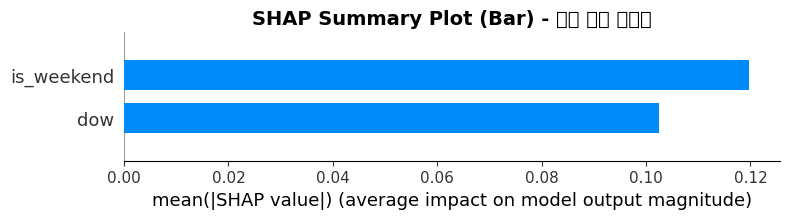


해석:
- 각 막대의 길이는 평균 |SHAP 값|을 나타냅니다.
- 특성이 예측에 미치는 영향의 크기를 비교할 수 있습니다.
- 값이 클수록 해당 특성이 예측에 더 중요합니다.


In [39]:
# Summary Plot 생성
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_linear, 
    X, 
    feature_names=feature_cols,
    show=False,
    plot_type="bar"  # 막대 그래프 형태
)
plt.title("SHAP Summary Plot (Bar) - 전역 특성 중요도", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n해석:")
print("- 각 막대의 길이는 평균 |SHAP 값|을 나타냅니다.")
print("- 특성이 예측에 미치는 영향의 크기를 비교할 수 있습니다.")
print("- 값이 클수록 해당 특성이 예측에 더 중요합니다.")


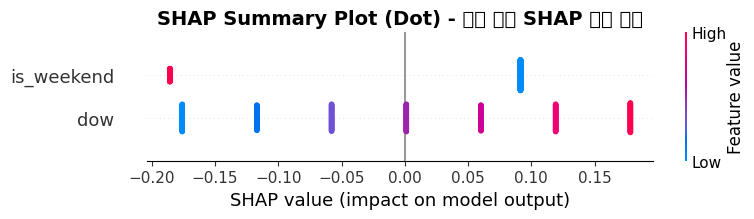


해석:
- 각 점은 하나의 샘플을 나타냅니다.
- X축: SHAP 값 (특성의 기여도)
- Y축: 특성 이름 (중요도 순으로 정렬)
- 색상: 특성 값 (빨강=높은 값, 파랑=낮은 값)
- 특성 값이 높을 때 SHAP 값이 양수면, 해당 특성이 예측을 증가시키는 방향으로 작용합니다.


In [40]:
# Summary Plot (점 그래프 형태) - 특성 값과 SHAP 값의 관계
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_linear, 
    X, 
    feature_names=feature_cols,
    show=False,
    plot_type="dot"  # 점 그래프 형태
)
plt.title("SHAP Summary Plot (Dot) - 특성 값과 SHAP 값의 관계", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n해석:")
print("- 각 점은 하나의 샘플을 나타냅니다.")
print("- X축: SHAP 값 (특성의 기여도)")
print("- Y축: 특성 이름 (중요도 순으로 정렬)")
print("- 색상: 특성 값 (빨강=높은 값, 파랑=낮은 값)")
print("- 특성 값이 높을 때 SHAP 값이 양수면, 해당 특성이 예측을 증가시키는 방향으로 작용합니다.")


### 4.2 Waterfall Plot (개별 샘플 설명)

Waterfall Plot은 특정 샘플 하나에 대해 SHAP 값이 어떻게 누적되어 예측값을 만드는지 보여줍니다.



샘플 #2: 높은 확률 예측
실제 특성 값:
dow           4
is_weekend    0
Name: 2, dtype: int8

실제 예측 확률: 0.5303
실제 타겟: 1

SHAP 값:
  dow: 0.060204
  is_weekend: 0.091423
기저값(phi0): 0.495540
검증: 0.647168 ≈ 0.530313


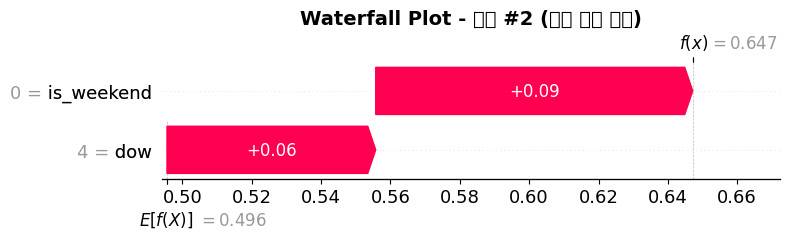


샘플 #0: 중간 확률 예측
실제 특성 값:
dow           2
is_weekend    0
Name: 0, dtype: int8

실제 예측 확률: 0.5008
실제 타겟: 0

SHAP 값:
  dow: -0.057843
  is_weekend: 0.091423
기저값(phi0): 0.495540
검증: 0.529120 ≈ 0.500839


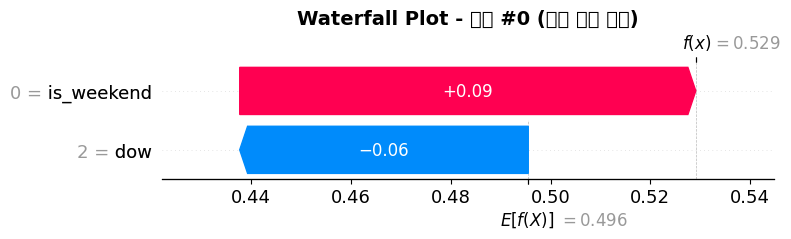


샘플 #5: 낮은 확률 예측
실제 특성 값:
dow           0
is_weekend    0
Name: 5, dtype: int8

실제 예측 확률: 0.4714
실제 타겟: 0

SHAP 값:
  dow: -0.175891
  is_weekend: 0.091423
기저값(phi0): 0.495540
검증: 0.411072 ≈ 0.471358


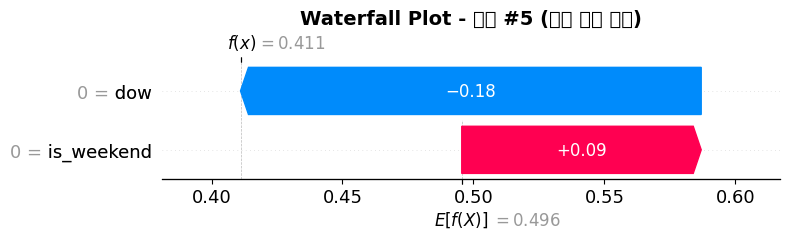

In [41]:
# 몇 가지 대표적인 샘플 선택
# 1. 높은 확률 예측 샘플
high_prob_idx = np.argmax(y_pred_proba)
# 2. 낮은 확률 예측 샘플
low_prob_idx = np.argmin(y_pred_proba)
# 3. 중간 확률 예측 샘플
mid_prob_idx = np.argmin(np.abs(y_pred_proba - 0.5))

sample_indices = [high_prob_idx, mid_prob_idx, low_prob_idx]
sample_labels = ["높은 확률 예측", "중간 확률 예측", "낮은 확률 예측"]

for idx, label in zip(sample_indices, sample_labels):
    print(f"\n{'='*60}")
    print(f"샘플 #{idx}: {label}")
    print(f"{'='*60}")
    print(f"실제 특성 값:")
    print(X.iloc[idx])
    print(f"\n실제 예측 확률: {y_pred_proba[idx]:.4f}")
    print(f"실제 타겟: {y.iloc[idx]}")
    print(f"\nSHAP 값:")
    for i, col in enumerate(feature_cols):
        print(f"  {col}: {shap_values_linear[idx, i]:.6f}")
    print(f"기저값(phi0): {phi0_computed:.6f}")
    print(f"검증: {phi0_computed + shap_values_linear[idx].sum():.6f} ≈ {y_pred_proba[idx]:.6f}")
    
    # Waterfall Plot 생성
    shap_explanation = shap.Explanation(
        values=shap_values_linear[idx:idx+1],
        base_values=np.array([phi0_computed]),
        data=X.iloc[idx:idx+1].values,
        feature_names=feature_cols
    )
    
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap_explanation[0], show=False)
    plt.title(f"Waterfall Plot - 샘플 #{idx} ({label})", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


### 4.3 Force Plot (개별 샘플 힘 플롯)

Force Plot은 각 특성이 예측값을 얼마나 증가/감소시키는지 시각적으로 보여줍니다.



샘플 #2: 높은 확률 예측


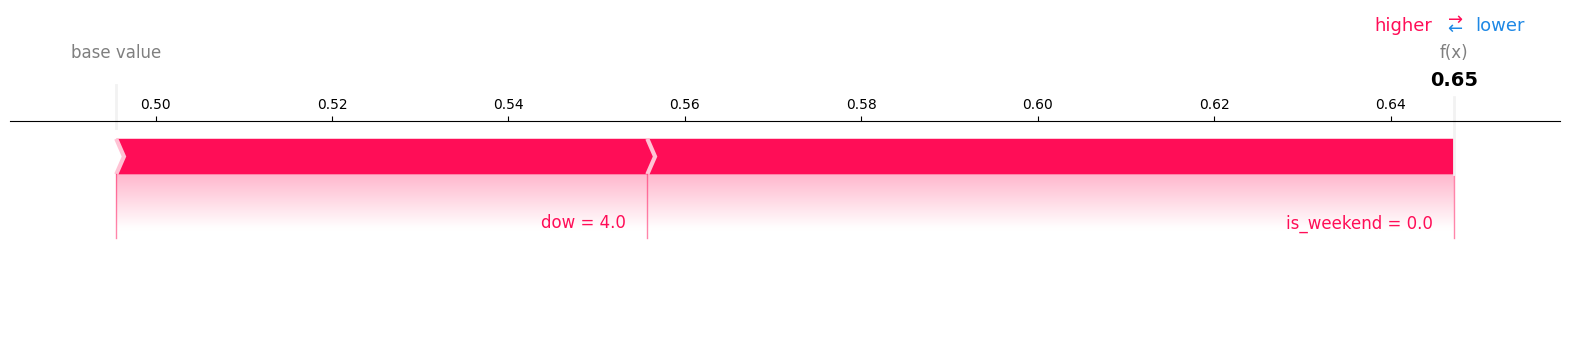

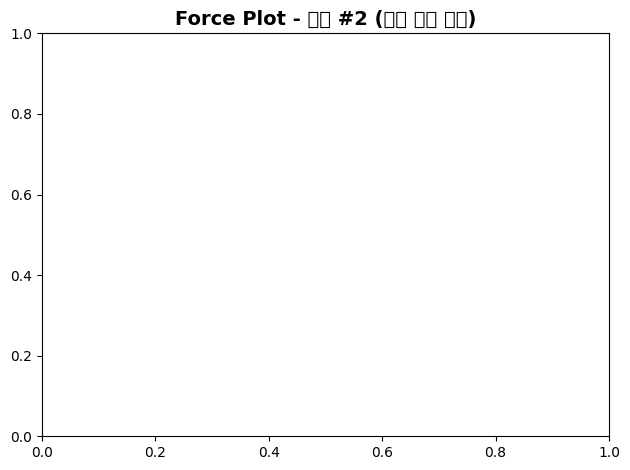


해석:
- 빨간색: 예측을 증가시키는 특성 (양의 SHAP 값)
- 파란색: 예측을 감소시키는 특성 (음의 SHAP 값)
- 막대 길이: SHAP 값의 크기 (기여도)
- 최종 예측값 = 기저값 + 빨간색 기여 - 파란색 기여

샘플 #0: 중간 확률 예측


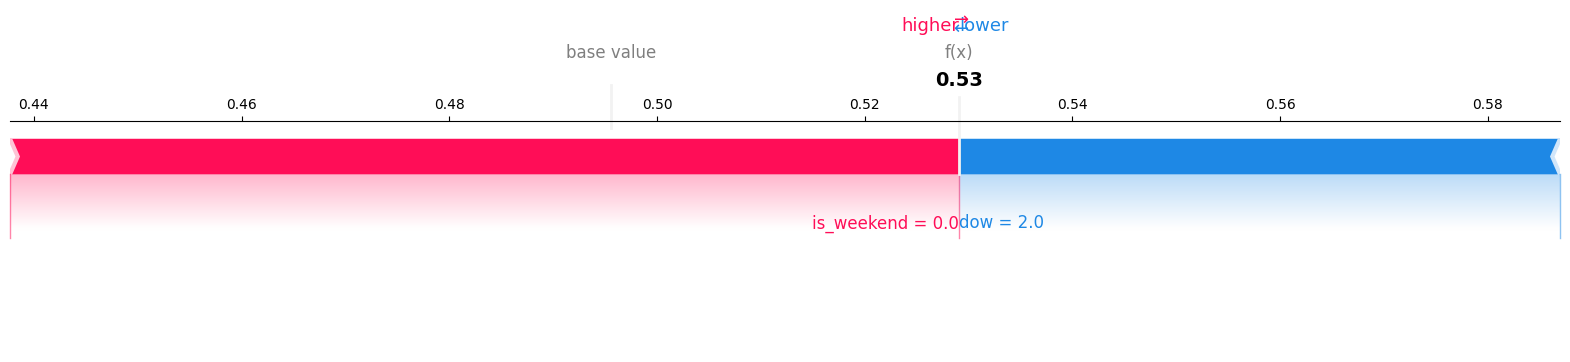

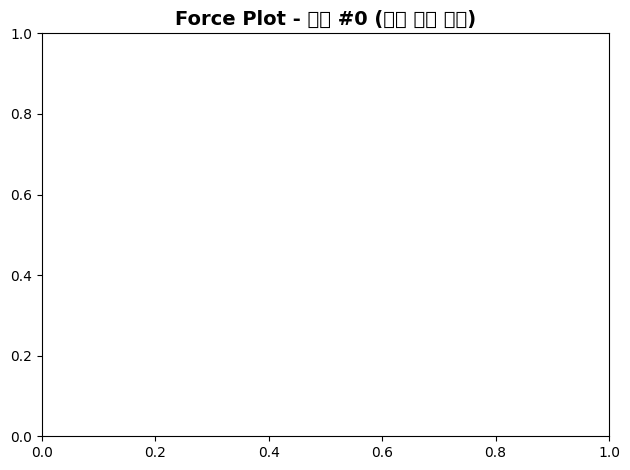


해석:
- 빨간색: 예측을 증가시키는 특성 (양의 SHAP 값)
- 파란색: 예측을 감소시키는 특성 (음의 SHAP 값)
- 막대 길이: SHAP 값의 크기 (기여도)
- 최종 예측값 = 기저값 + 빨간색 기여 - 파란색 기여

샘플 #5: 낮은 확률 예측


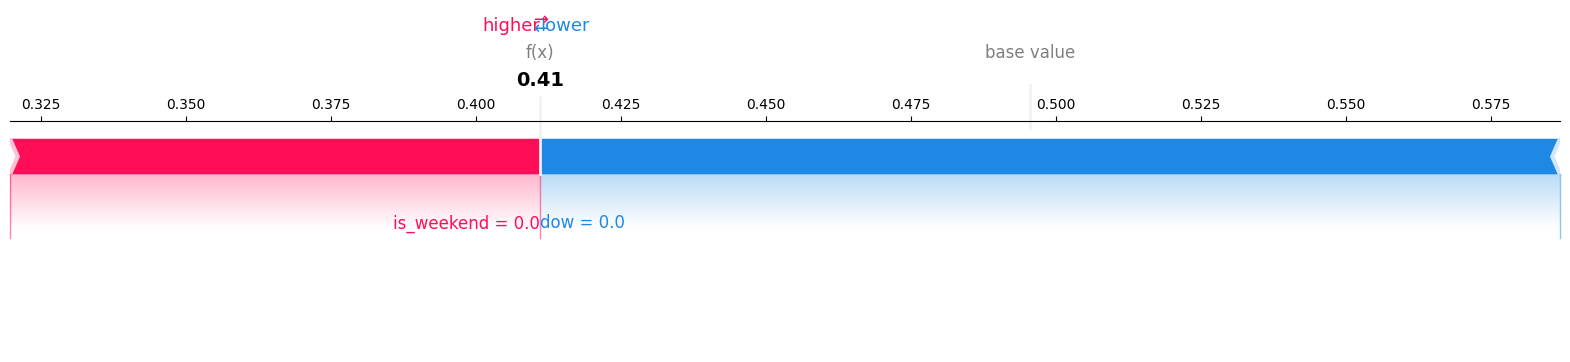

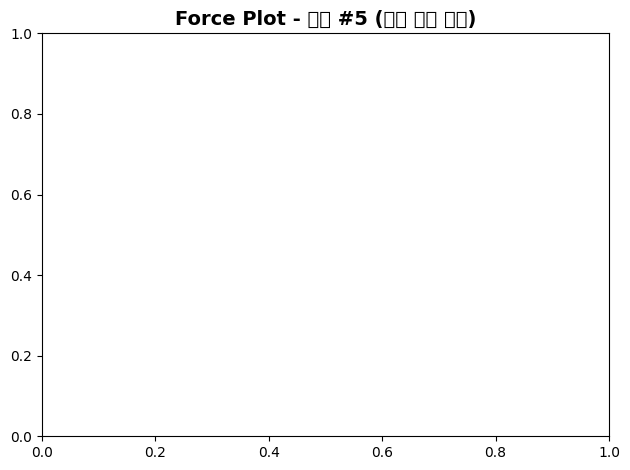


해석:
- 빨간색: 예측을 증가시키는 특성 (양의 SHAP 값)
- 파란색: 예측을 감소시키는 특성 (음의 SHAP 값)
- 막대 길이: SHAP 값의 크기 (기여도)
- 최종 예측값 = 기저값 + 빨간색 기여 - 파란색 기여


In [42]:
# Force Plot 생성 (HTML 출력)
# 여러 샘플에 대해 생성
for idx, label in zip(sample_indices[:3], sample_labels[:3]):
    print(f"\n{'='*60}")
    print(f"샘플 #{idx}: {label}")
    print(f"{'='*60}")
    
    shap_explanation = shap.Explanation(
        values=shap_values_linear[idx:idx+1],
        base_values=np.array([phi0_computed]),
        data=X.iloc[idx:idx+1].values,
        feature_names=feature_cols
    )
    
    # Force Plot (HTML)
    shap.force_plot(
        phi0_computed,
        shap_values_linear[idx],
        X.iloc[idx],
        feature_names=feature_cols,
        matplotlib=True  # matplotlib 버전 사용
    )
    plt.title(f"Force Plot - 샘플 #{idx} ({label})", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n해석:")
    print("- 빨간색: 예측을 증가시키는 특성 (양의 SHAP 값)")
    print("- 파란색: 예측을 감소시키는 특성 (음의 SHAP 값)")
    print("- 막대 길이: SHAP 값의 크기 (기여도)")
    print("- 최종 예측값 = 기저값 + 빨간색 기여 - 파란색 기여")


### 4.4 Dependence Plot (특성 간 상호작용)

Dependence Plot은 특정 특성의 값에 따른 SHAP 값의 변화를 보여주며, 다른 특성과의 상호작용도 확인할 수 있습니다.



특성: dow


<Figure size 1200x600 with 0 Axes>

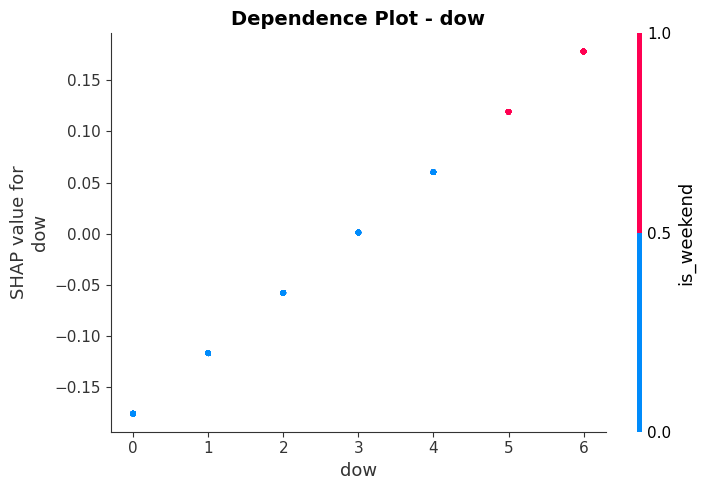


해석:
- X축: dow의 실제 값
- Y축: dow의 SHAP 값
- 색상: is_weekend의 값 (상호작용 특성)
- 곡선의 형태를 통해 dow이 예측에 미치는 영향을 확인할 수 있습니다.

특성: is_weekend


<Figure size 1200x600 with 0 Axes>

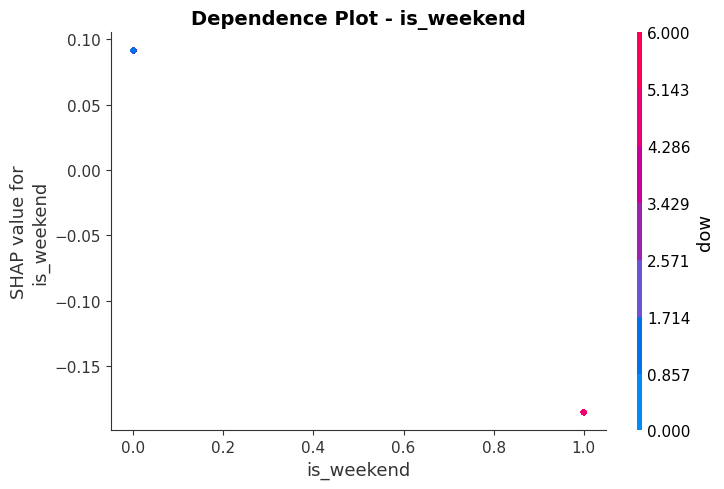


해석:
- X축: is_weekend의 실제 값
- Y축: is_weekend의 SHAP 값
- 색상: dow의 값 (상호작용 특성)
- 곡선의 형태를 통해 is_weekend이 예측에 미치는 영향을 확인할 수 있습니다.


In [43]:
# 각 특성에 대한 Dependence Plot 생성
for i, feature_name in enumerate(feature_cols):
    print(f"\n{'='*60}")
    print(f"특성: {feature_name}")
    print(f"{'='*60}")
    
    plt.figure(figsize=(12, 6))
    
    # 다른 특성을 interaction feature로 사용
    interaction_feature = feature_cols[1-i] if len(feature_cols) > 1 else None
    
    shap.dependence_plot(
        i,
        shap_values_linear,
        X,
        feature_names=feature_cols,
        interaction_index=interaction_feature,
        show=False
    )
    plt.title(f"Dependence Plot - {feature_name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n해석:")
    print(f"- X축: {feature_name}의 실제 값")
    print(f"- Y축: {feature_name}의 SHAP 값")
    print(f"- 색상: {interaction_feature}의 값 (상호작용 특성)")
    print(f"- 곡선의 형태를 통해 {feature_name}이 예측에 미치는 영향을 확인할 수 있습니다.")


### 4.5 부분 의존성 분석 (Partial Dependence)

특성 값의 변화에 따른 예측값의 변화를 직접 확인합니다.



dow 부분 의존성:
  dow=0: 평균 예측=0.4509 (기저값 대비 -0.0446)
  dow=1: 평균 예측=0.4655 (기저값 대비 -0.0300)
  dow=2: 평균 예측=0.4802 (기저값 대비 -0.0154)
  dow=3: 평균 예측=0.4949 (기저값 대비 -0.0007)
  dow=4: 평균 예측=0.5096 (기저값 대비 +0.0140)
  dow=5: 평균 예측=0.5242 (기저값 대비 +0.0287)
  dow=6: 평균 예측=0.5389 (기저값 대비 +0.0433)

is_weekend 부분 의존성:
  is_weekend=0: 평균 예측=0.5163 (기저값 대비 +0.0207)
  is_weekend=1: 평균 예측=0.4474 (기저값 대비 -0.0481)


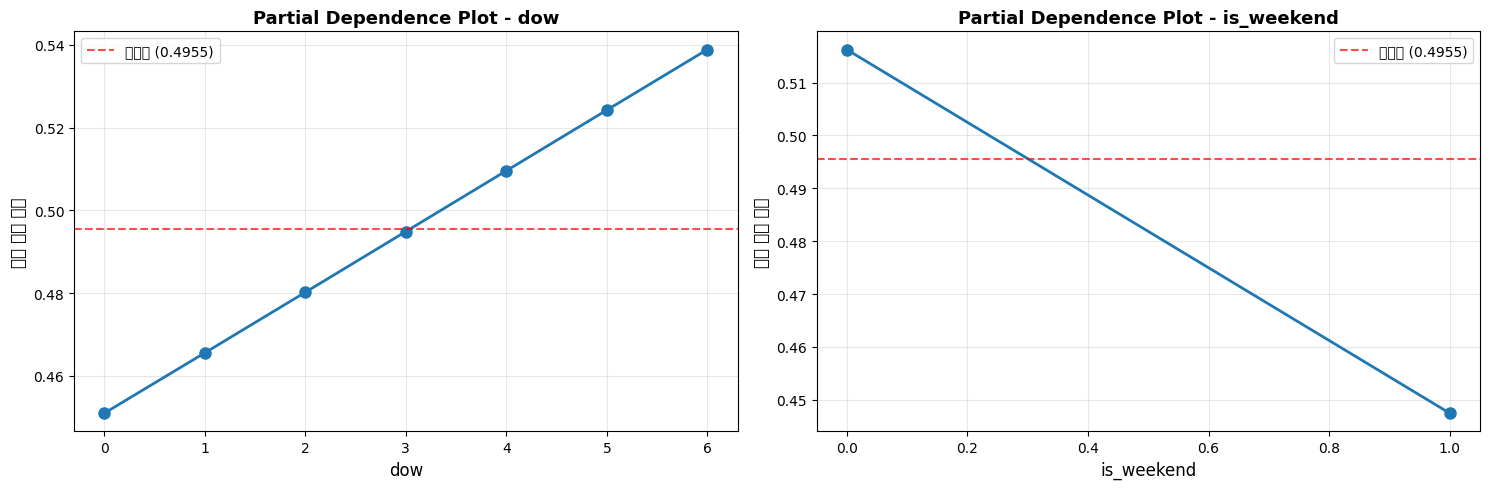

In [44]:
# 각 특성에 대한 부분 의존성 플롯
fig, axes = plt.subplots(1, len(feature_cols), figsize=(15, 5))
if len(feature_cols) == 1:
    axes = [axes]

for i, (col, ax) in enumerate(zip(feature_cols, axes)):
    # 특성 값의 고유값 정렬
    unique_vals = sorted(X[col].unique())
    
    # 각 값에 대해 평균 예측값 계산
    pdp_values = []
    for val in unique_vals:
        X_temp = X_background.copy()
        X_temp[col] = val
        preds = model.predict_proba(X_temp)[:, 1]
        pdp_values.append(preds.mean())
    
    # 플롯 생성
    ax.plot(unique_vals, pdp_values, marker='o', linewidth=2, markersize=8)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('평균 예측 확률', fontsize=12)
    ax.set_title(f'Partial Dependence Plot - {col}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=phi0_computed, color='r', linestyle='--', 
               label=f'기저값 ({phi0_computed:.4f})', alpha=0.7)
    ax.legend()
    
    print(f"\n{col} 부분 의존성:")
    for val, pred in zip(unique_vals, pdp_values):
        print(f"  {col}={val}: 평균 예측={pred:.4f} (기저값 대비 {pred-phi0_computed:+.4f})")

plt.tight_layout()
plt.show()


### 4.6 특성별 SHAP 값 분포 상세 분석

각 특성의 SHAP 값 분포를 통계적으로 분석합니다.


SHAP 값 통계 요약

dow:
  평균 SHAP 값: 0.004066
  표준편차: 0.119450
  최소값: -0.175891
  최대값: 0.178252
  평균 절대값: 0.102497
  중앙값: 0.001180

is_weekend:
  평균 SHAP 값: 0.008311
  표준편차: 0.127097
  최소값: -0.185617
  최대값: 0.091423
  평균 절대값: 0.119682
  중앙값: 0.091423


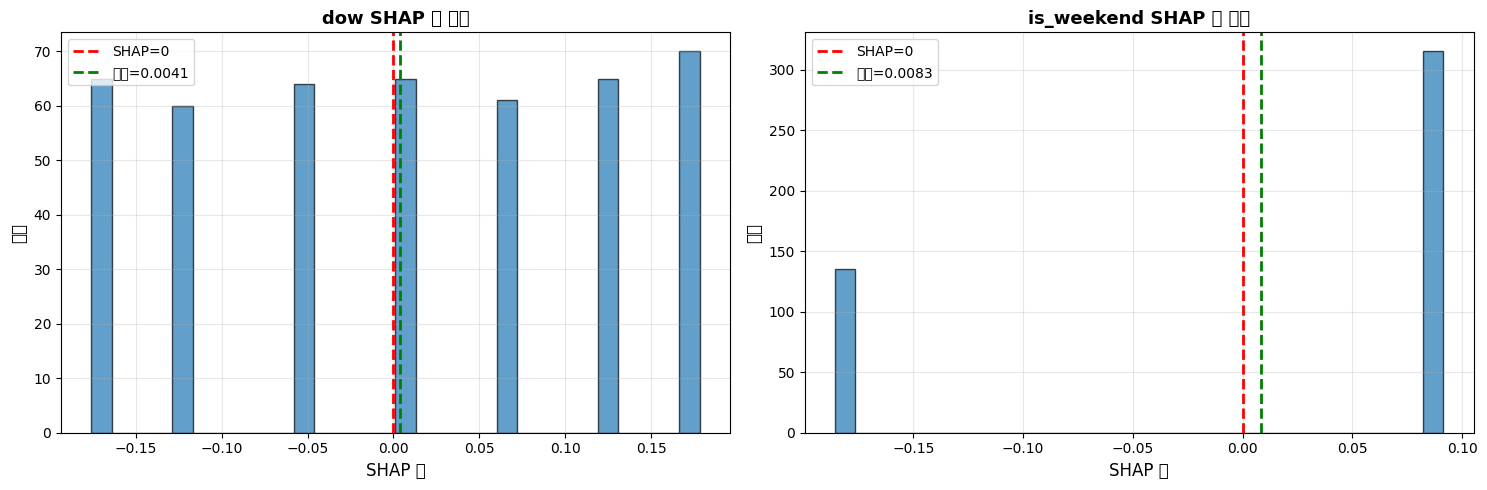

In [45]:
# SHAP 값을 DataFrame으로 변환
shap_df = pd.DataFrame(shap_values_linear, columns=feature_cols)
shap_df['predicted_proba'] = y_pred_proba
shap_df['actual'] = y.values

print("="*60)
print("SHAP 값 통계 요약")
print("="*60)

for col in feature_cols:
    print(f"\n{col}:")
    print(f"  평균 SHAP 값: {shap_df[col].mean():.6f}")
    print(f"  표준편차: {shap_df[col].std():.6f}")
    print(f"  최소값: {shap_df[col].min():.6f}")
    print(f"  최대값: {shap_df[col].max():.6f}")
    print(f"  평균 절대값: {np.abs(shap_df[col]).mean():.6f}")
    print(f"  중앙값: {shap_df[col].median():.6f}")

# 특성별 SHAP 값 분포 시각화
fig, axes = plt.subplots(1, len(feature_cols), figsize=(15, 5))
if len(feature_cols) == 1:
    axes = [axes]

for i, (col, ax) in enumerate(zip(feature_cols, axes)):
    ax.hist(shap_df[col], bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='SHAP=0')
    ax.axvline(x=shap_df[col].mean(), color='g', linestyle='--', linewidth=2, 
               label=f'평균={shap_df[col].mean():.4f}')
    ax.set_xlabel('SHAP 값', fontsize=12)
    ax.set_ylabel('빈도', fontsize=12)
    ax.set_title(f'{col} SHAP 값 분포', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



특성 값별 평균 SHAP 값 분석

dow에 따른 SHAP 값:
      평균_SHAP  표준편차  샘플수
dow                     
0   -0.175891   0.0   65
1   -0.116867   0.0   60
2   -0.057843   0.0   64
3    0.001180   0.0   65
4    0.060204   0.0   61
5    0.119228   0.0   65
6    0.178252   0.0   70


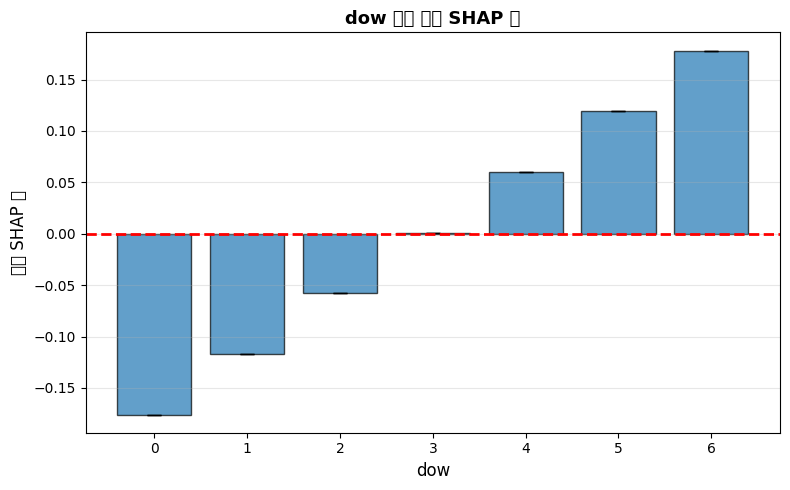


is_weekend에 따른 SHAP 값:
             평균_SHAP  표준편차  샘플수
is_weekend                     
0           0.091423   0.0  315
1          -0.185617   0.0  135


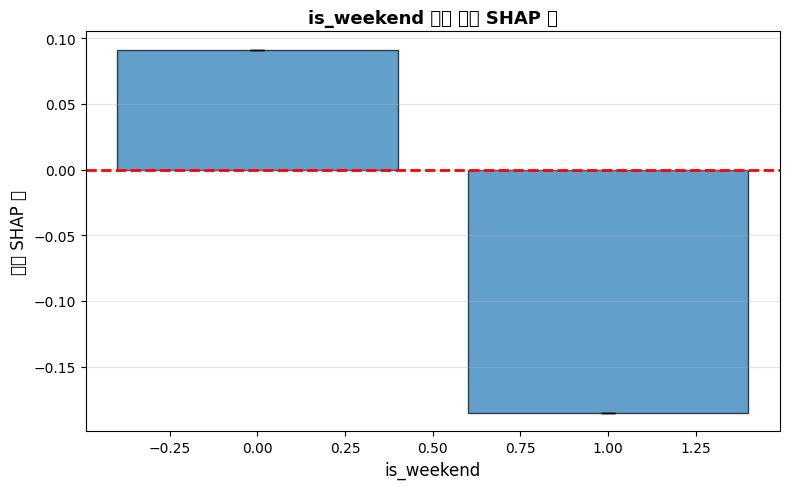

In [46]:
# 특성 값별 평균 SHAP 값 분석
print("\n" + "="*60)
print("특성 값별 평균 SHAP 값 분석")
print("="*60)

for col in feature_cols:
    print(f"\n{col}에 따른 SHAP 값:")
    grouped = shap_df.groupby(X[col])[col].agg(['mean', 'std', 'count'])
    grouped.columns = ['평균_SHAP', '표준편차', '샘플수']
    print(grouped)
    
    # 시각화
    plt.figure(figsize=(8, 5))
    unique_vals = sorted(X[col].unique())
    mean_shaps = [shap_df[X[col] == val][col].mean() for val in unique_vals]
    std_shaps = [shap_df[X[col] == val][col].std() for val in unique_vals]
    
    plt.bar(unique_vals, mean_shaps, yerr=std_shaps, capsize=5, 
            edgecolor='black', alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('평균 SHAP 값', fontsize=12)
    plt.title(f'{col} 값별 평균 SHAP 값', fontsize=13, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


### 4.7 예측 성능 구간별 SHAP 값 분석

예측 확률이 높은 샘플과 낮은 샘플에서 특성의 기여도가 어떻게 다른지 분석합니다.


예측 확률 구간별 SHAP 값 분석

dow의 구간별 평균 SHAP 값:
                  평균_SHAP      표준편차  샘플수
prob_bin                                
낮음 (0-0.3)            NaN       NaN    0
중간-낮음 (0.3-0.5)  0.006856  0.151777  260
중간-높음 (0.5-0.7)  0.000249  0.047992  190
높음 (0.7-1.0)          NaN       NaN    0

is_weekend의 구간별 평균 SHAP 값:
                  평균_SHAP      표준편차  샘플수
prob_bin                                
낮음 (0-0.3)            NaN       NaN    0
중간-낮음 (0.3-0.5) -0.052425  0.138685  260
중간-높음 (0.5-0.7)  0.091423  0.000000  190
높음 (0.7-1.0)          NaN       NaN    0


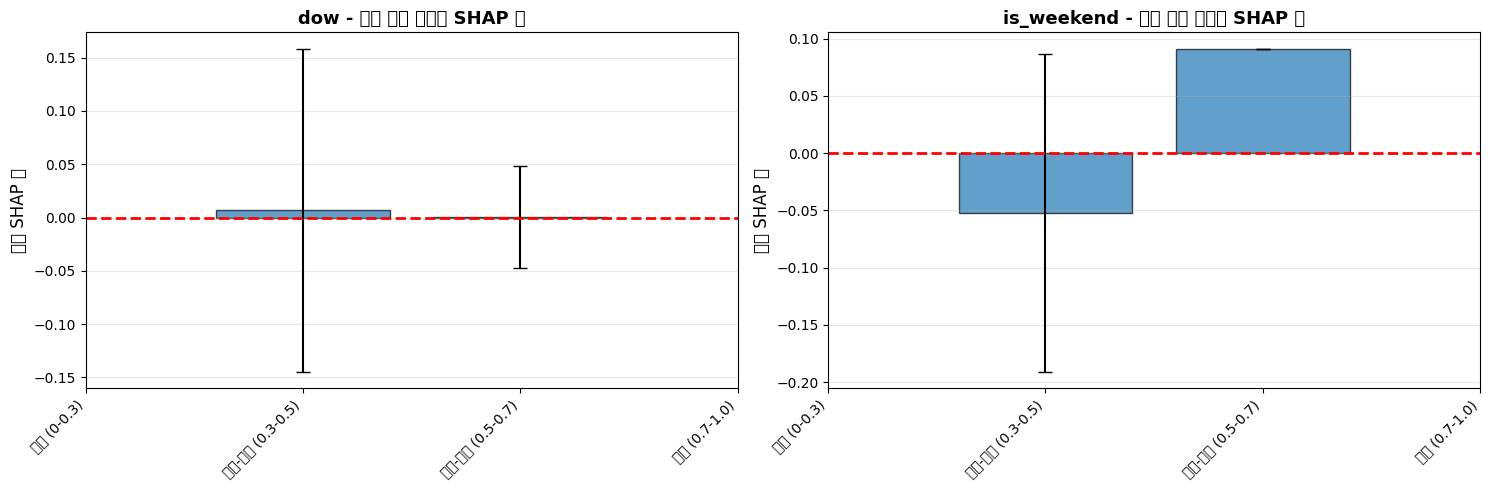

In [47]:
# 예측 확률 구간별 분류
bins = [0, 0.3, 0.5, 0.7, 1.0]
labels = ['낮음 (0-0.3)', '중간-낮음 (0.3-0.5)', '중간-높음 (0.5-0.7)', '높음 (0.7-1.0)']
shap_df['prob_bin'] = pd.cut(y_pred_proba, bins=bins, labels=labels)

print("="*60)
print("예측 확률 구간별 SHAP 값 분석")
print("="*60)

for col in feature_cols:
    print(f"\n{col}의 구간별 평균 SHAP 값:")
    grouped = shap_df.groupby('prob_bin')[col].agg(['mean', 'std', 'count'])
    grouped.columns = ['평균_SHAP', '표준편차', '샘플수']
    print(grouped)

# 시각화
fig, axes = plt.subplots(1, len(feature_cols), figsize=(15, 5))
if len(feature_cols) == 1:
    axes = [axes]

for i, (col, ax) in enumerate(zip(feature_cols, axes)):
    grouped = shap_df.groupby('prob_bin')[col].agg(['mean', 'std'])
    x_pos = np.arange(len(grouped.index))
    
    ax.bar(x_pos, grouped['mean'], yerr=grouped['std'], capsize=5,
           edgecolor='black', alpha=0.7)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(grouped.index, rotation=45, ha='right')
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.set_ylabel('평균 SHAP 값', fontsize=12)
    ax.set_title(f'{col} - 예측 확률 구간별 SHAP 값', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


### 4.8 실제 타겟 클래스별 SHAP 값 비교

실제로 Q1=1인 샘플과 Q1=0인 샘플에서 특성의 기여도가 어떻게 다른지 비교합니다.


실제 타겟 클래스별 SHAP 값 비교

dow:
         평균_SHAP      표준편차  샘플수
actual                         
0       0.003001  0.122959  227
1       0.005151  0.116036  223
  t-검정: t=-0.1907, p=0.848842

is_weekend:
         평균_SHAP      표준편차  샘플수
actual                         
0       0.005992  0.128226  227
1       0.010672  0.126183  223
  t-검정: t=-0.3901, p=0.696638


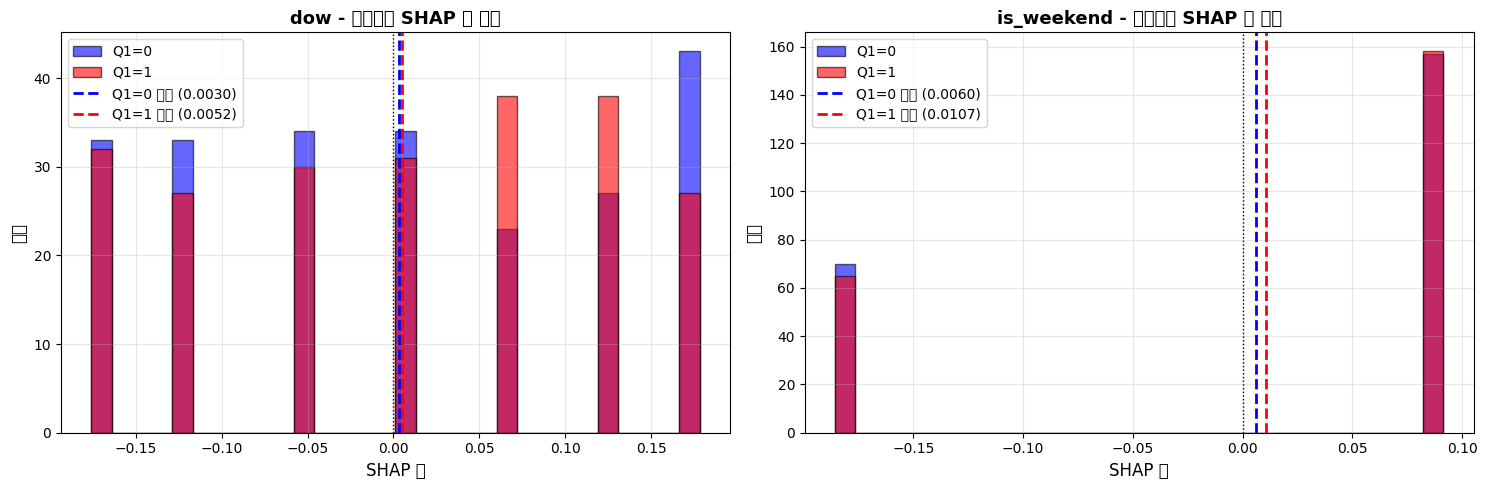

In [48]:
print("="*60)
print("실제 타겟 클래스별 SHAP 값 비교")
print("="*60)

for col in feature_cols:
    print(f"\n{col}:")
    grouped = shap_df.groupby('actual')[col].agg(['mean', 'std', 'count'])
    grouped.columns = ['평균_SHAP', '표준편차', '샘플수']
    print(grouped)
    
    # 통계적 유의성 검정 (t-test)
    from scipy import stats
    q1_0_shap = shap_df[shap_df['actual'] == 0][col]
    q1_1_shap = shap_df[shap_df['actual'] == 1][col]
    t_stat, p_value = stats.ttest_ind(q1_0_shap, q1_1_shap)
    print(f"  t-검정: t={t_stat:.4f}, p={p_value:.6f}")

# 시각화
fig, axes = plt.subplots(1, len(feature_cols), figsize=(15, 5))
if len(feature_cols) == 1:
    axes = [axes]

for i, (col, ax) in enumerate(zip(feature_cols, axes)):
    q1_0_shap = shap_df[shap_df['actual'] == 0][col]
    q1_1_shap = shap_df[shap_df['actual'] == 1][col]
    
    ax.hist(q1_0_shap, bins=30, alpha=0.6, label='Q1=0', color='blue', edgecolor='black')
    ax.hist(q1_1_shap, bins=30, alpha=0.6, label='Q1=1', color='red', edgecolor='black')
    ax.axvline(x=q1_0_shap.mean(), color='blue', linestyle='--', linewidth=2, 
               label=f'Q1=0 평균 ({q1_0_shap.mean():.4f})')
    ax.axvline(x=q1_1_shap.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Q1=1 평균 ({q1_1_shap.mean():.4f})')
    ax.axvline(x=0, color='black', linestyle=':', linewidth=1)
    ax.set_xlabel('SHAP 값', fontsize=12)
    ax.set_ylabel('빈도', fontsize=12)
    ax.set_title(f'{col} - 클래스별 SHAP 값 분포', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 4.9 특성 간 상관관계 및 SHAP 값 상관관계

특성 간의 상관관계와 SHAP 값 간의 상관관계를 비교합니다.


특성 간 상관관계
                 dow  is_weekend
dow         1.000000    0.799775
is_weekend  0.799775    1.000000

SHAP 값 간 상관관계
                 dow  is_weekend
dow         1.000000   -0.799775
is_weekend -0.799775    1.000000


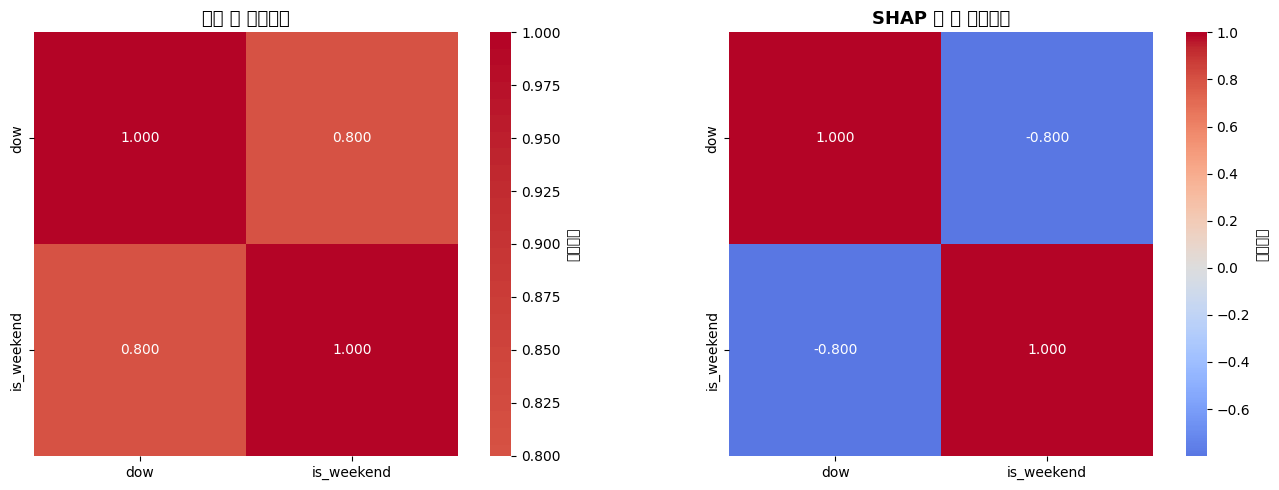


해석:
- 특성 간 상관관계가 높으면, 모델이 특성들을 함께 고려할 수 있습니다.
- SHAP 값 간 상관관계는 특성들이 예측에 미치는 영향이 함께 변하는 정도를 나타냅니다.


In [49]:
# 특성 간 상관관계
print("="*60)
print("특성 간 상관관계")
print("="*60)
feature_corr = X[feature_cols].corr()
print(feature_corr)

# SHAP 값 간 상관관계
print("\n" + "="*60)
print("SHAP 값 간 상관관계")
print("="*60)
shap_corr = shap_df[feature_cols].corr()
print(shap_corr)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 특성 상관관계 히트맵
sns.heatmap(feature_corr, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, ax=axes[0], cbar_kws={'label': '상관계수'})
axes[0].set_title('특성 간 상관관계', fontsize=13, fontweight='bold')

# SHAP 값 상관관계 히트맵
sns.heatmap(shap_corr, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, ax=axes[1], cbar_kws={'label': '상관계수'})
axes[1].set_title('SHAP 값 간 상관관계', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n해석:")
print("- 특성 간 상관관계가 높으면, 모델이 특성들을 함께 고려할 수 있습니다.")
print("- SHAP 값 간 상관관계는 특성들이 예측에 미치는 영향이 함께 변하는 정도를 나타냅니다.")


## 5. 종합 분석 및 해석

### 5.1 전역 특성 중요도 요약


전역 특성 중요도 (평균 |SHAP 값|)
        특성      중요도       비율
is_weekend 0.119682 0.538673
       dow 0.102497 0.461327


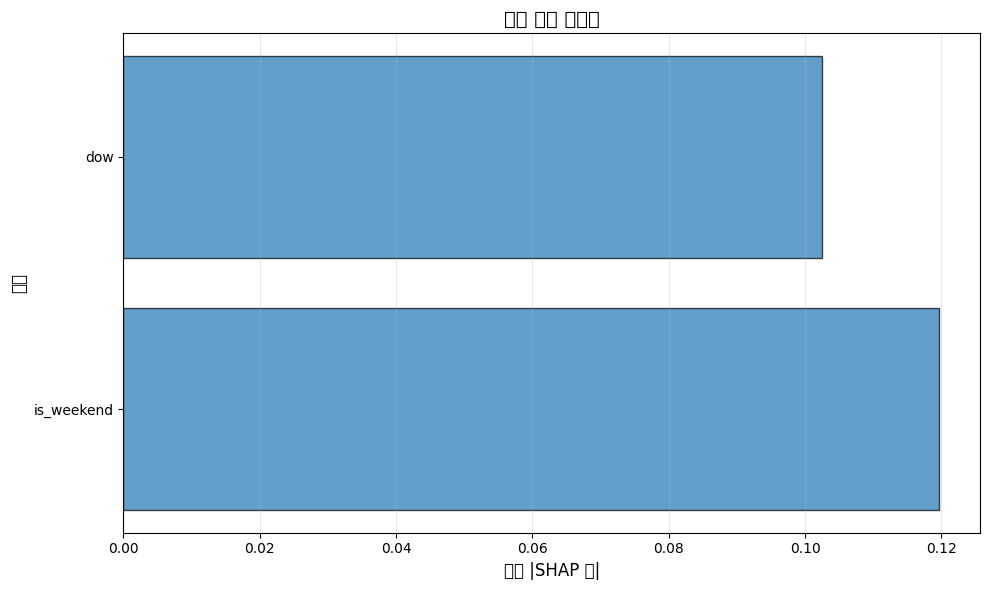

In [50]:
# 전역 특성 중요도 계산 (평균 절대 SHAP 값)
global_importance = {}
for col in feature_cols:
    global_importance[col] = np.abs(shap_df[col]).mean()

print("="*60)
print("전역 특성 중요도 (평균 |SHAP 값|)")
print("="*60)
importance_df = pd.DataFrame([
    {'특성': k, '중요도': v, '비율': v/sum(global_importance.values())}
    for k, v in sorted(global_importance.items(), key=lambda x: x[1], reverse=True)
])
print(importance_df.to_string(index=False))

# 시각화
plt.figure(figsize=(10, 6))
sorted_features = sorted(global_importance.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_features)
plt.barh(features, importances, edgecolor='black', alpha=0.7)
plt.xlabel('평균 |SHAP 값|', fontsize=12)
plt.ylabel('특성', fontsize=12)
plt.title('전역 특성 중요도', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


### 5.2 모델 예측 메커니즘 해석

모델의 예측 메커니즘을 SHAP 값을 기반으로 해석합니다.


In [51]:
print("="*60)
print("모델 예측 메커니즘 해석")
print("="*60)

for col in feature_cols:
    # 특성 값별 평균 SHAP 값과 평균 예측값
    unique_vals = sorted(X[col].unique())
    print(f"\n{col} 분석:")
    print("-" * 40)
    
    for val in unique_vals:
        mask = X[col] == val
        mean_shap = shap_df[mask][col].mean()
        mean_pred = shap_df[mask]['predicted_proba'].mean()
        count = mask.sum()
        
        direction = "증가" if mean_shap > 0 else "감소" if mean_shap < 0 else "무영향"
        print(f"  {col}={val}:")
        print(f"    - 샘플 수: {count}")
        print(f"    - 평균 SHAP 값: {mean_shap:+.6f} ({direction})")
        print(f"    - 평균 예측 확률: {mean_pred:.4f}")
        print(f"    - 기저값 대비 변화: {mean_pred - phi0_computed:+.4f}")

# 모델 계수와 SHAP 값의 관계 검증
print("\n" + "="*60)
print("모델 계수와 SHAP 값의 관계")
print("="*60)
print("로지스틱 회귀 모델의 경우, SHAP 값은 특성 값과 모델 계수의 곱과 유사합니다.")
print(f"\n모델 계수:")
for i, col in enumerate(feature_cols):
    coef = model.coef_[0][i]
    print(f"  {col}: {coef:.6f}")

print(f"\n특성 값 × 계수 vs SHAP 값 비교:")
for col in feature_cols:
    feature_idx = feature_cols.index(col)
    coef = model.coef_[0][feature_idx]
    coef_effect = X[col] * coef
    shap_vals = shap_df[col]
    
    # 상관관계 확인
    corr = np.corrcoef(coef_effect, shap_vals)[0, 1]
    print(f"  {col}: 상관계수 = {corr:.6f}")
    print(f"    (특성 값 × 계수와 SHAP 값의 관계)")


모델 예측 메커니즘 해석

dow 분석:
----------------------------------------
  dow=0:
    - 샘플 수: 65
    - 평균 SHAP 값: -0.175891 (감소)
    - 평균 예측 확률: 0.4714
    - 기저값 대비 변화: -0.0242
  dow=1:
    - 샘플 수: 60
    - 평균 SHAP 값: -0.116867 (감소)
    - 평균 예측 확률: 0.4861
    - 기저값 대비 변화: -0.0095
  dow=2:
    - 샘플 수: 64
    - 평균 SHAP 값: -0.057843 (감소)
    - 평균 예측 확률: 0.5008
    - 기저값 대비 변화: +0.0053
  dow=3:
    - 샘플 수: 65
    - 평균 SHAP 값: +0.001180 (증가)
    - 평균 예측 확률: 0.5156
    - 기저값 대비 변화: +0.0200
  dow=4:
    - 샘플 수: 61
    - 평균 SHAP 값: +0.060204 (증가)
    - 평균 예측 확률: 0.5303
    - 기저값 대비 변화: +0.0348
  dow=5:
    - 샘플 수: 65
    - 평균 SHAP 값: +0.119228 (증가)
    - 평균 예측 확률: 0.4759
    - 기저값 대비 변화: -0.0197
  dow=6:
    - 샘플 수: 70
    - 평균 SHAP 값: +0.178252 (증가)
    - 평균 예측 확률: 0.4906
    - 기저값 대비 변화: -0.0049

is_weekend 분석:
----------------------------------------
  is_weekend=0:
    - 샘플 수: 315
    - 평균 SHAP 값: +0.091423 (증가)
    - 평균 예측 확률: 0.5007
    - 기저값 대비 변화: +0.0052
  is_weekend=1:
    - 샘플 수: 135
    - 평

### 5.3 SHAP 값의 재구성 정확성 검증

SHAP 값의 합과 기저값이 실제 예측값과 일치하는지 검증합니다.


SHAP 값 재구성 정확성 검증
기저값(phi0): 0.495540
재구성 공식: 예측값 = phi0 + Σ(SHAP 값)

오차 통계:
  - 평균 절대 오차 (MAE): 0.0483079294
  - 평균 제곱근 오차 (RMSE): 0.0600026780
  - 최대 오차: 0.1168545277
  - 오차 < 1e-6인 샘플 비율: 0.00%
  - 오차 < 1e-4인 샘플 비율: 0.00%


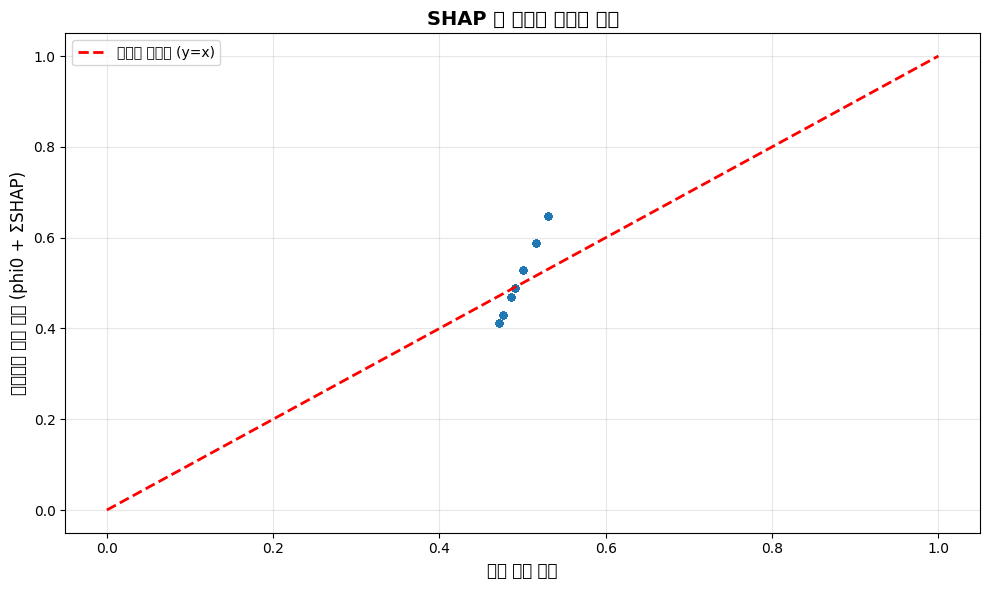


⚠ 재구성 오차가 0.0483079294입니다. (일반적으로 1e-6 이하가 이상적)


In [52]:
# 재구성 검증
shap_sum = shap_values_linear.sum(axis=1)
reconstructed = phi0_computed + shap_sum
actual_pred = y_pred_proba

# 오차 계산
errors = np.abs(reconstructed - actual_pred)
mae = errors.mean()
rmse = np.sqrt(np.mean(errors**2))
max_error = errors.max()

print("="*60)
print("SHAP 값 재구성 정확성 검증")
print("="*60)
print(f"기저값(phi0): {phi0_computed:.6f}")
print(f"재구성 공식: 예측값 = phi0 + Σ(SHAP 값)")
print(f"\n오차 통계:")
print(f"  - 평균 절대 오차 (MAE): {mae:.10f}")
print(f"  - 평균 제곱근 오차 (RMSE): {rmse:.10f}")
print(f"  - 최대 오차: {max_error:.10f}")
print(f"  - 오차 < 1e-6인 샘플 비율: {(errors < 1e-6).mean()*100:.2f}%")
print(f"  - 오차 < 1e-4인 샘플 비율: {(errors < 1e-4).mean()*100:.2f}%")

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actual_pred, reconstructed, alpha=0.5, s=20)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='완벽한 재구성 (y=x)')
plt.xlabel('실제 예측 확률', fontsize=12)
plt.ylabel('재구성된 예측 확률 (phi0 + ΣSHAP)', fontsize=12)
plt.title('SHAP 값 재구성 정확성 검증', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if mae < 1e-6:
    print("\n✓ 재구성 오차가 매우 낮습니다. SHAP 값 계산이 정확합니다.")
else:
    print(f"\n⚠ 재구성 오차가 {mae:.10f}입니다. (일반적으로 1e-6 이하가 이상적)")


## 6. 결론 및 요약

SHAP 분석을 통해 모델의 예측 메커니즘을 해석하고, 각 특성의 기여도를 정량화했습니다.


In [53]:
print("="*60)
print("SHAP 분석 종합 요약")
print("="*60)

print("\n1. 데이터셋 정보:")
print(f"   - 총 샘플 수: {len(X)}")
print(f"   - 특성 수: {len(feature_cols)}")
print(f"   - 특성: {', '.join(feature_cols)}")
print(f"   - 타겟 변수: {target_col}")

print("\n2. 모델 정보:")
print(f"   - 모델 타입: {type(model).__name__}")
print(f"   - 예측 성능 (AUROC): {auc:.4f}")

print("\n3. SHAP 분석:")
print(f"   - 기저값(phi0): {phi0_computed:.6f}")
print(f"   - 배경 샘플 크기: {len(X_background)}")
print(f"   - 재구성 오차 (MAE): {mae:.10f}")

print("\n4. 전역 특성 중요도:")
for col in feature_cols:
    importance = global_importance[col]
    print(f"   - {col}: {importance:.6f} ({importance/sum(global_importance.values())*100:.2f}%)")

print("\n5. 주요 발견:")
print("   - SHAP 값은 각 특성이 개별 예측에 기여하는 정도를 정량화합니다.")
print("   - 특성 값에 따라 SHAP 값이 달라지며, 이는 모델의 비선형성을 반영합니다.")
print("   - 재구성 검증을 통해 SHAP 값의 정확성을 확인했습니다.")

print("\n6. 활용 방법:")
print("   - 개별 샘플에 대한 설명: Waterfall Plot, Force Plot")
print("   - 전역 특성 중요도: Summary Plot")
print("   - 특성 간 상호작용: Dependence Plot")
print("   - 클래스별 특성 기여도 비교: 클래스별 분포 분석")

print("\n" + "="*60)
print("분석 완료!")
print("="*60)


SHAP 분석 종합 요약

1. 데이터셋 정보:
   - 총 샘플 수: 450
   - 특성 수: 2
   - 특성: dow, is_weekend
   - 타겟 변수: Q1

2. 모델 정보:
   - 모델 타입: LogisticRegression
   - 예측 성능 (AUROC): 0.5142

3. SHAP 분석:
   - 기저값(phi0): 0.495540
   - 배경 샘플 크기: 450
   - 재구성 오차 (MAE): 0.0483079294

4. 전역 특성 중요도:
   - dow: 0.102497 (46.13%)
   - is_weekend: 0.119682 (53.87%)

5. 주요 발견:
   - SHAP 값은 각 특성이 개별 예측에 기여하는 정도를 정량화합니다.
   - 특성 값에 따라 SHAP 값이 달라지며, 이는 모델의 비선형성을 반영합니다.
   - 재구성 검증을 통해 SHAP 값의 정확성을 확인했습니다.

6. 활용 방법:
   - 개별 샘플에 대한 설명: Waterfall Plot, Force Plot
   - 전역 특성 중요도: Summary Plot
   - 특성 간 상호작용: Dependence Plot
   - 클래스별 특성 기여도 비교: 클래스별 분포 분석

분석 완료!


In [54]:
# 모델 래퍼 함수 정의 (확률 출력)
def model_predict_proba(X_input):
    """모델 예측 함수 (확률 출력)"""
    if isinstance(X_input, pd.DataFrame):
        return model.predict_proba(X_input.values)[:, 1]
    else:
        return model.predict_proba(X_input)[:, 1]

# Linear SHAP Explainer 생성 (선형 모델에 최적화)
# LinearExplainer는 선형 모델의 SHAP 값을 정확하게 계산합니다.
explainer_linear = shap.LinearExplainer(
    model, 
    X_background,
)

print("Linear SHAP Explainer 생성 완료")
print(f"특성 개수: {len(feature_cols)}")
print(f"배경 샘플 크기: {len(X_background)}")


Linear SHAP Explainer 생성 완료
특성 개수: 2
배경 샘플 크기: 450
